Mustafa Kemal AYDIN

NO : 200905023

In [1]:
# Kütüphaneleri Eklemek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

for dirname , _, filenames in os.walk('Clean_Dataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Verilere genel bir bakış
df = pd.read_csv('Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
# Gereksiz kolonların 'Unnamed: 0' olarak silinmesi/düşürülmesi
df = df.drop('Unnamed: 0',axis = 1)

In [4]:
# Veriler hakkında genel bilgi
df.info()
# verinin alanı
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


(300153, 11)

Hedef kolonumuz 'price' kolonu olacak.

In [5]:
# Economy ve Business olarak gruplandırarak uçuş sayılarına bakalım
df2=df.groupby(['flight', 'airline', 'class'], as_index = False).count()
df2['class'].value_counts()


class
Economy     1560
Business     295
Name: count, dtype: int64

Economy sınıfına ait uçuşlar Business sınıfına ait uçuşlardan fazla.

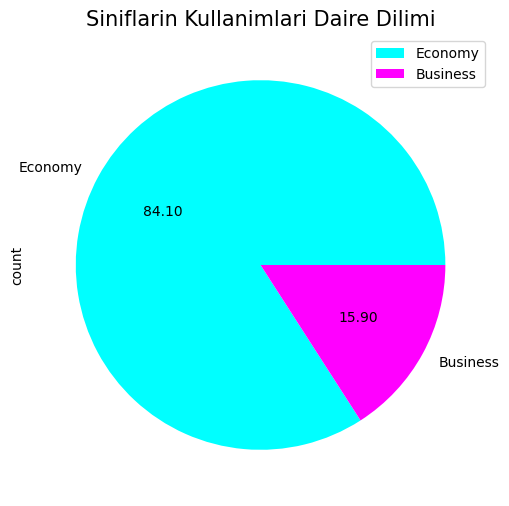

In [6]:
plt.figure(figsize = (8,6))
df2['class'].value_counts().plot(kind = 'pie', textprops = {'color' : 'black'}, autopct = '%.2f', cmap = 'cool')
plt.title('Siniflarin Kullanimlari Daire Dilimi',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()

In [7]:
# Dosya yedeklemesi (geri dönüş dosyası)
df_bk = df.copy()

PREPROCESS işlemleri

In [8]:
# LABEL ENCODER
# Scikit Learn kütüphanesinden Label Encoder fonksiyonunu kullanarak
# Kolonlardaki değerleri sayısal bir forma dönüştürme işlemi
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])


In [9]:
# Bağımlı verileri X'e ve Bağımsız verileri Y'ye depolama/kaydetme
x = df.drop(['price'], axis = 1)
y = df['price']

In [10]:
# MODEL SELECTION --> TRAIN AND TEST AYRIMI
# Veriyi Training bölümü ve Testing bölümü olarak ayırmak OVER FITTING önlenmiş olur.
from sklearn.model_selection import train_test_split
# random state'e bir değer verilmezse her çalıştırmada farklı bir sonuç alırız ve tutartlı olmaz
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 35)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((210107, 10), (90046, 10), (210107,), (90046,))

In [11]:
# MIN MAX SCALER
# Veride en büyük değere 1, en küçük değeri 0 belirleyerek sıralama yapar
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler(feature_range = (0, 1))
x_train = mmscaler.fit_transform(x_train)
x_test = mmscaler.fit_transform(x_test)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [12]:
# Rapor bloğunun hazırlanması
rapor = {'Model Name':[], 
'Mean_Absolute_Error_MAE':[] ,
'Adj_R_Square':[] ,
'Root_Mean_Squared_Error_RMSE':[] ,
'Mean_Absolute_Percentage_Error_MAPE':[] ,
'Mean_Squared_Error_MSE':[] ,
'Root_Mean_Squared_Log_Error_RMSLE':[] ,
'R2_score':[]}
Results = pd.DataFrame(rapor)
Results.head()

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


Regression ve Regressor modellerinin oluşturulması

Linear Regression Default Parameters

LinearRegression(fit_intercept = True, copy_X = True, n_jobs = None, positive = False)

fit_intercept --> intercept, ortak değişkenlerin 0 olduğu durum sayısıdır.
Eğer amaç özelliğin önemini belirlemek ise kullanılmaz
Eğer amaç performans ise kullanılır.
True olarak belirlersek modelin iki değer arasında kalmamış olmasını mecburen iki değerden birini seçmesini sağlamış oluruz.

copy_x --> Linear Regression başlamadan önce X(verinin)' in kopyasını alır böylelikle
orjinal verimize herhangi bir etkide bulunmamış olur, orjinal veri saklanır

n_jobs --> Linear Regression' da hesaplanacak/işlenecek işlerin işelyen sayısını belirler.
İşlemi hızlandırır ama doğruluk oranı düşer. Default olarak NONE yani 1 adet işlemci/hesaplayıcı
-1 ise tüm işlemciler

positive --> negatif sayılar kullanılıyor ise bunları pozitife dönüştürme için kullanılır

Decision Tree Regression Default Parameters

DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)

criterion --> Veri ayırmada (split) duyar, kalite durumunu ayarlama.
MSE(squared_error), aykırı değerlere karşı duyarlı olma.
FriedmanMSE ve MSE ile arasındaki fark Kirlilik azaltma metodlarının farklı olması.
Absolute Error doğru değer ile geri kalanlar arasındaki fark.
poisson verideki 0 ların sayısına göre işlem yapma

splitter --> hangi özelliğin hedef olacağını belirler.
Best, öncelikli özelliği hedef alır.
Random, herhangi bir özelliği hedef alır.

max_depth --> maximum dallanma/ağaç sayısı.

min_samples_split --> minumum dallanma sayısı (internal node) 2 default değer 1 sonuç/kayıt çıkarır.

min_sapmples_leaf --> minumum yaprak sayısı (leaf node) olabilme koşulu

min_weight_fraction_leaf --> ağırlık verilen özellikler bu parametrede belirtilen ağırlık kadar
ağırlığı yok ise önemsenmezler/kullanılmazlar

max_features --> Split işleminde kullanılacak en fazla özellik sayısı

random_state --> aynı rastgele oluşturulmuş liste kodunda işlem yapmasını sağlar

max_leaf_nodes --> en fazla yaprak sayısını belirler

min_impurity_decrease --> model bu parametreyi split den önce kirlilik eşik değeri olarak alır
gereksiz ayırmayı önler.

ccp_alpha --> ağaç yapısının büyüklüğünü ayarlamak için kullanılır, sayı arttıkça budanma artar.

Random Forest Regression Default Parameters

RandomForestRegressor(n_estimators=100,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

n_estimators --> Ağaç sayısı, arttıkça daha iyi performans verir, ama zaman alır.

bootstrap -->  ortaklaşa ağaç kullanımı durumudur

oob_score --> aykırı verilerin genelleştirme skorunda kullanılma durumu

verbose --> ayrıntı katsayısı, arttıkça performans düşer

warmstart --> önceki çalıştırmadan sonuçları da ekler

K Neighbors Regression Default Parameters

KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

n_neighbors --> bölümleme sayısı, arttıkça performans düşer

weights --> ağırlık paylaşımı
Uniform, her özellik eşit olarak ağırlık alır
distance, bölümleme noktalarına yakın olanlar daha fazla ağırlık alır
callable, kullanıcı tarafından girilen dizinin uzaklık sonucu ağırlık

algorithm --> ball_tree, kd_tree kullanabilir; brute (brute force) aramsı yapabilir
auto, değerlere göre hangisi en uygun ise onu seçer

leaf_size --> arttıkça kullanılan kaynak miktarı artar probleme göre sayısı belirlenir

p --> 1 ise manhattan uzaklık, 2 ise minkowski uzaklık kullanılır



In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Regression objelerinin varsayılan parametreler ile oluşturulması
modelmlg = LinearRegression(fit_intercept = True, copy_X = True, n_jobs = None, positive = False)
modeldcr = DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=35, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
modelrfr = RandomForestRegressor(n_estimators=200,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=35, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
modelKNN = KNeighborsRegressor(n_neighbors=8, weights='distance', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

In [15]:
# Matrix modellerinin oluşturulması

MM = [modelmlg, modeldcr, modelKNN, modelrfr]
for models in MM:

    # Train verileri modellere yüklemek
    models.fit(x_train, y_train)

    # Test verisi ile Modelin Tahmini
    y_pred = models.predict(x_test)

    # Model isminin yazdırılması
    print('Model ismi: ', models)

    # MAE, MSE, RMSE, R2 Score, RMSLE ölçülerinin modeller için hesaplanması
    from sklearn import metrics

    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),3))  
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred),3))  
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred),6))
    print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),3))
    
    # MAPE (Mean Absolute Percentage Error) hesaplama fonksiyonu

    def MAPE (y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # MAPE değerinin hesaplanması 
    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')

    # R2 skorunun hesaplanması
    r_squared = round(metrics.r2_score(y_test, y_pred),6)
    adjusted_r_squared = round(1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1),6)
    print('Adj R Square: ', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')
    
    # ----------------------------------------------------------------

    # Raporun Yapısı
    new_row = {'Model Name' : models,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred),
               'Adj_R_Square' : adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               'Mean_Absolute_Percentage_Error_MAPE' : result,
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred),
               'Root_Mean_Squared_Log_Error_RMSLE': np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
               'R2_score' : metrics.r2_score(y_test, y_pred)}

Model ismi:  LinearRegression()
Mean Absolute Error (MAE): 4638.36
Mean Squared Error (MSE): 49205194.463
Root Mean Squared Error (RMSE): 7014.641
R2_score: 0.904901
Root Mean Squared Log Error (RMSLE): 8.856
Mean Absolute Percentage Error (MAPE): 43.61 %
Adj R Square:  0.904898
------------------------------------------------------------------------------------------------------------
Model ismi:  DecisionTreeRegressor(random_state=35)
Mean Absolute Error (MAE): 925.164
Mean Squared Error (MSE): 8885172.621
Root Mean Squared Error (RMSE): 2980.801
R2_score: 0.982828
Root Mean Squared Log Error (RMSLE): 8.0
Mean Absolute Percentage Error (MAPE): 6.22 %
Adj R Square:  0.982827
------------------------------------------------------------------------------------------------------------
Model ismi:  KNeighborsRegressor(algorithm='kd_tree', n_neighbors=8, weights='distance')
Mean Absolute Error (MAE): 1838.742
Mean Squared Error (MSE): 14061577.759
Root Mean Squared Error (RMSE): 3749.877
R

R2 ve R Square Sonuçlarına Göre

    1. Random Forest Regressor
    2. Decision Tree Regressor
    3. KNeighbors Regressor
    4. Linear Regression

Veriyi eğitmeye başlayalım

Random Forest Regression kullanarak modelin eğitilmesi

In [16]:
modelrfr.fit(x_train, y_train)

# test verisi ile modelin tahmin edilmesi
y_pred = modelrfr.predict(x_test)

In [17]:
cikti = pd.DataFrame({'Price_actual' : y_test, 'Price_pred' : y_pred})
sonuc = df_bk.merge(cikti, left_index = True, right_index = True)

# 10 adet örnek gösterimi
sonuc.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
177031,Air_India,AI-543,Hyderabad,Morning,one,Evening,Chennai,Economy,7.67,10,14428,14428,17900.320
181060,Vistara,UK-824,Chennai,Night,one,Morning,Delhi,Economy,12.08,7,13023,13023,12855.610
256420,Air_India,AI-501,Bangalore,Afternoon,one,Evening,Hyderabad,Business,6.00,9,56476,56476,56476.000
257910,Vistara,UK-858,Bangalore,Early_Morning,one,Afternoon,Hyderabad,Business,5.58,33,37985,37985,37985.000
242827,Vistara,UK-940,Mumbai,Evening,one,Evening,Chennai,Business,20.58,20,72125,72125,70095.560
293922,Vistara,UK-826,Chennai,Afternoon,one,Night,Bangalore,Business,8.42,12,44144,44144,44172.560
270585,Vistara,UK-708,Kolkata,Night,one,Night,Hyderabad,Business,26.50,9,52175,52175,52597.240
40867,Vistara,UK-819,Delhi,Afternoon,two_or_more,Night,Chennai,Economy,8.83,36,8719,8719,8767.735
156131,Air_India,AI-507,Hyderabad,Morning,one,Evening,Delhi,Economy,7.58,31,5577,5577,5556.180
82679,Air_India,AI-635,Mumbai,Early_Morning,one,Evening,Chennai,Economy,12.58,39,7019,7019,5371.490


Tahmin ve Gerçek Veri Grafiği

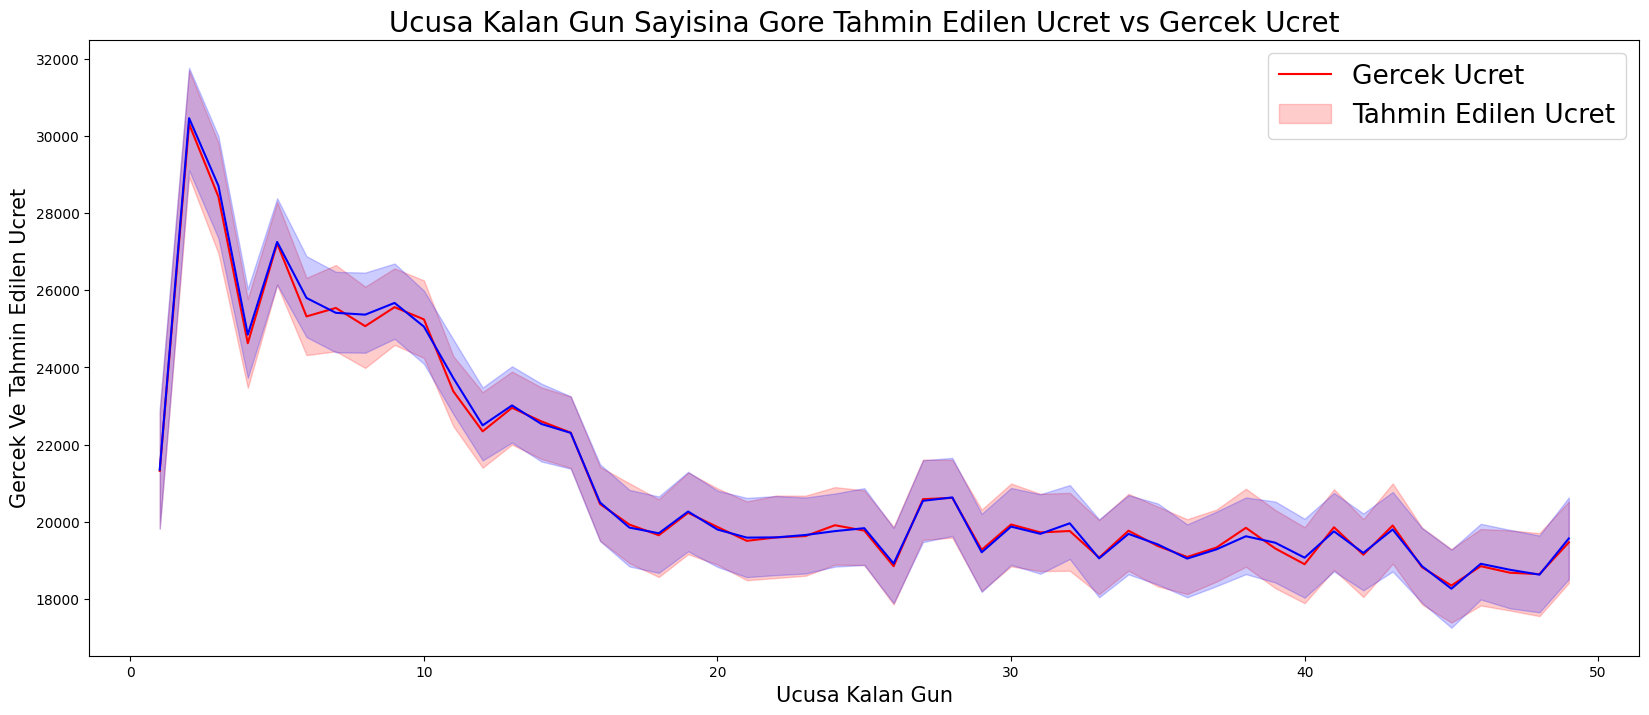

In [18]:
plt.figure(figsize=(20,8))
sns.lineplot(data=sonuc,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=sonuc,x='days_left',y='Price_pred',color='blue')
plt.title('Ucusa Kalan Gun Sayisina Gore Tahmin Edilen Ucret vs Gercek Ucret',fontsize=20)
plt.legend(labels=['Gercek Ucret','Tahmin Edilen Ucret'],fontsize=19)
plt.xlabel('Ucusa Kalan Gun',fontsize=15)
plt.ylabel('Gercek Ve Tahmin Edilen Ucret',fontsize=15)
plt.show()

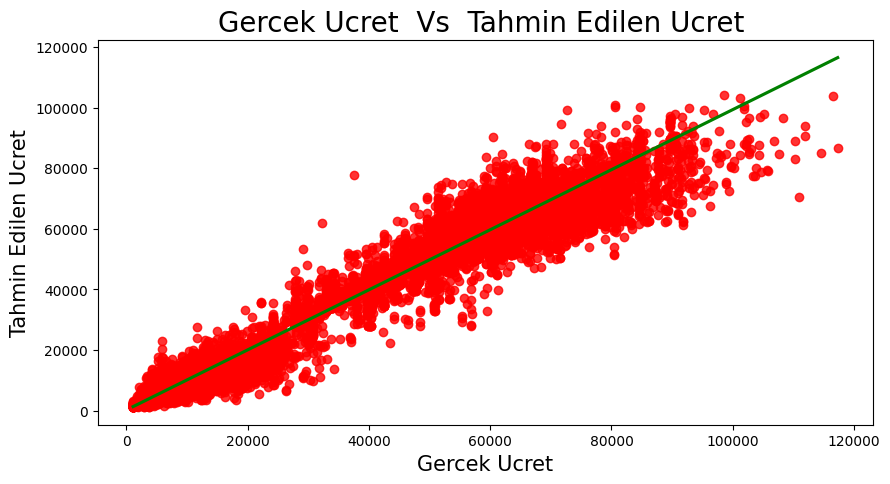

In [19]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=sonuc,scatter_kws={"color": "red"}, line_kws={"color": "green"})
plt.title('Gercek Ucret  Vs  Tahmin Edilen Ucret ',fontsize=20)
plt.xlabel('Gercek Ucret',fontsize=15)
plt.ylabel('Tahmin Edilen Ucret',fontsize=15)
plt.show()

Decision Tree Regression kullanılarak modelin eğitilmesi

In [20]:
modeldcr.fit(x_train, y_train)

# test verisi ile modelin tahmin edilmesi
y_pred = modeldcr.predict(x_test)

In [21]:
cikti2 = pd.DataFrame({'Price_actual' : y_test, 'Price_pred' : y_pred})
sonuc2 = df_bk.merge(cikti2, left_index = True, right_index = True)

# 10 adet örnek gösterimi
sonuc.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
285364,Air_India,AI-559,Hyderabad,Early_Morning,one,Night,Kolkata,Business,15.67,49,51707,51707,51707.000
257906,Air_India,AI-503,Bangalore,Evening,one,Morning,Hyderabad,Business,18.08,32,56476,56476,56476.000
170151,AirAsia,I5-972,Hyderabad,Evening,one,Night,Bangalore,Economy,5.58,45,2738,2738,2756.145
83420,Indigo,6E-434,Mumbai,Afternoon,one,Night,Chennai,Economy,4.33,45,1890,1890,2743.600
192054,Indigo,6E-6113,Chennai,Afternoon,one,Night,Mumbai,Economy,7.08,36,2646,2646,2893.695
31963,GO_FIRST,G8-101,Delhi,Early_Morning,one,Afternoon,Hyderabad,Economy,9.83,26,5407,5407,5411.300
231214,Vistara,UK-651,Mumbai,Evening,one,Evening,Bangalore,Business,26.17,16,48213,48213,56323.445
261414,Vistara,UK-776,Kolkata,Evening,one,Evening,Delhi,Business,24.50,4,66063,66063,72194.795
220405,Vistara,UK-985,Delhi,Evening,one,Afternoon,Hyderabad,Business,16.42,24,59537,59537,59537.000
233440,Air_India,AI-806,Mumbai,Early_Morning,one,Night,Bangalore,Business,12.08,41,54608,54608,54608.000


Tahmin ve Gerçek Veri Grafiği

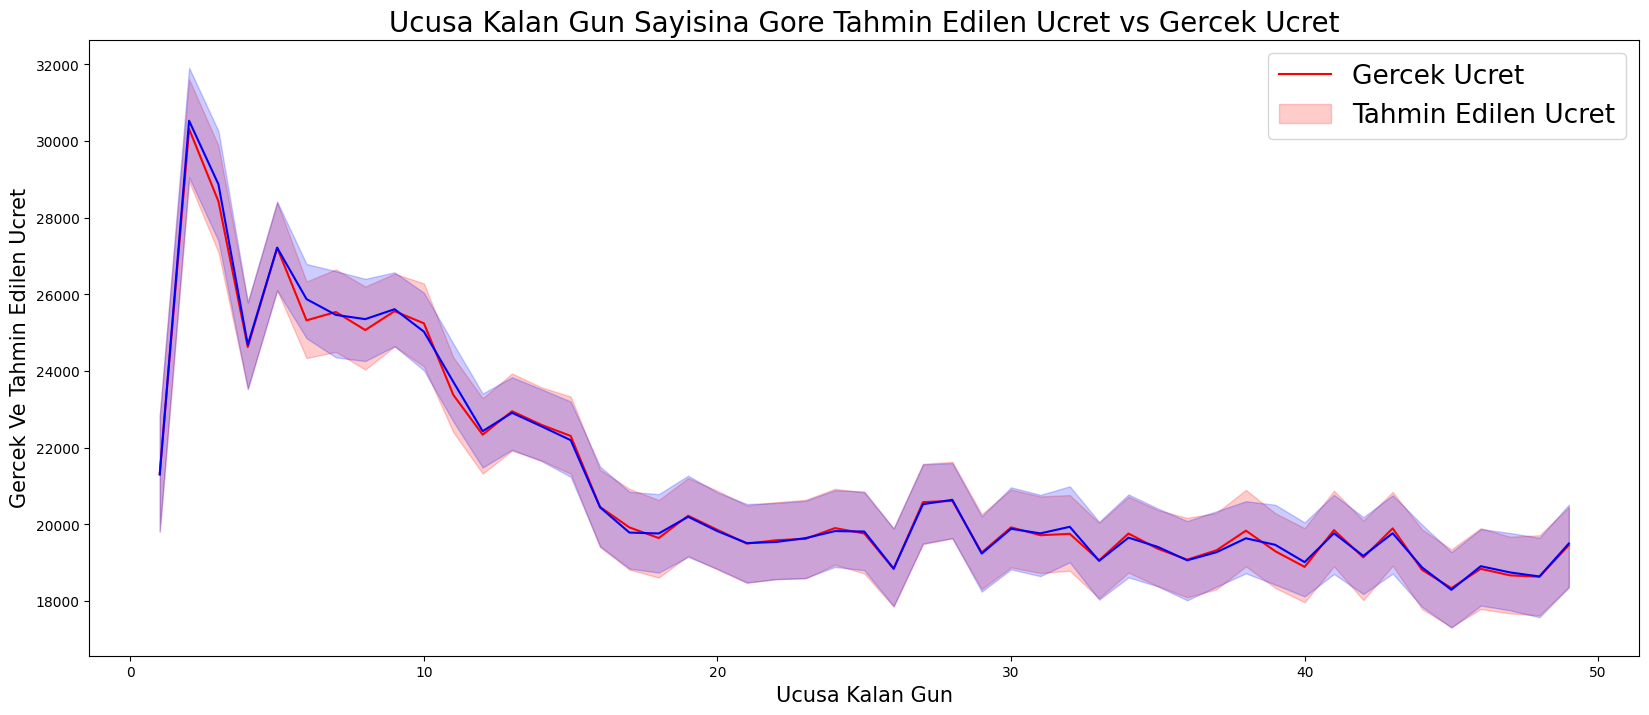

In [22]:
plt.figure(figsize=(20,8))
sns.lineplot(data=sonuc2,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=sonuc2,x='days_left',y='Price_pred',color='blue')
plt.title('Ucusa Kalan Gun Sayisina Gore Tahmin Edilen Ucret vs Gercek Ucret',fontsize=20)
plt.legend(labels=['Gercek Ucret','Tahmin Edilen Ucret'],fontsize=19)
plt.xlabel('Ucusa Kalan Gun',fontsize=15)
plt.ylabel('Gercek Ve Tahmin Edilen Ucret',fontsize=15)
plt.show()

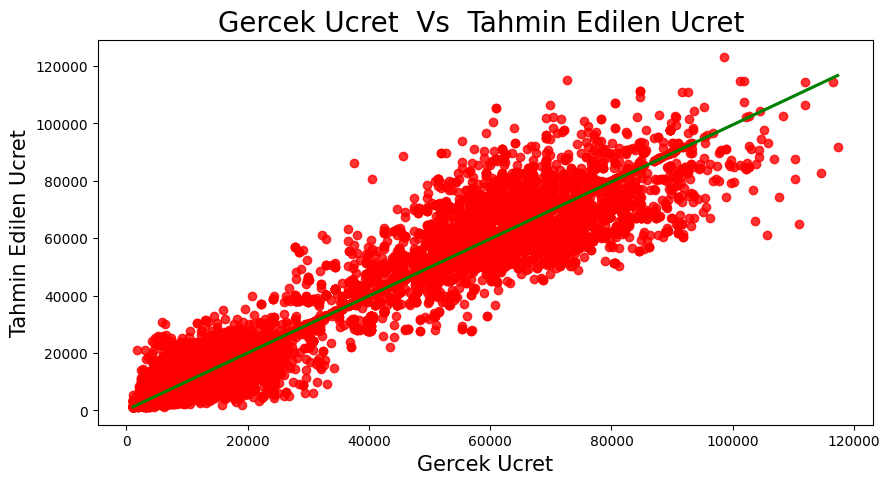

In [23]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=sonuc2,scatter_kws={"color": "red"}, line_kws={"color": "green"})
plt.title('Gercek Ucret  Vs  Tahmin Edilen Ucret ',fontsize=20)
plt.xlabel('Gercek Ucret',fontsize=15)
plt.ylabel('Tahmin Edilen Ucret',fontsize=15)
plt.show()

KNeighbors Regression kullanarak modelin eğitilmesi

In [24]:
modelKNN.fit(x_train, y_train)

# test verisi ile modelin tahmin edilmesi
y_pred = modelKNN.predict(x_test)

In [25]:
cikti3 = pd.DataFrame({'Price_actual' : y_test, 'Price_pred' : y_pred})
sonuc3 = df_bk.merge(cikti3, left_index = True, right_index = True)

# 10 adet örnek gösterimi
sonuc.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
143388,Air_India,AI-763,Kolkata,Early_Morning,one,Morning,Hyderabad,Economy,27.50,10,12054,12054,12352.255
45796,Air_India,AI-651,Mumbai,Morning,one,Evening,Delhi,Economy,9.92,16,8190,8190,7551.480
151605,AirAsia,I5-2991,Kolkata,Night,one,Morning,Chennai,Economy,10.92,39,3961,3961,3961.000
88566,Indigo,6E-6067,Bangalore,Evening,one,Late_Night,Delhi,Economy,8.75,24,3788,3788,3893.255
85246,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Economy,8.42,8,10744,10744,10832.465
218988,Air_India,AI-423,Delhi,Early_Morning,one,Morning,Kolkata,Business,5.08,48,27976,27976,30755.270
76664,Air_India,AI-671,Mumbai,Morning,one,Night,Hyderabad,Economy,11.58,45,3402,3402,3754.870
175608,Vistara,UK-898,Hyderabad,Early_Morning,two_or_more,Evening,Kolkata,Economy,10.42,43,9433,9433,9432.580
49583,Vistara,UK-873,Mumbai,Early_Morning,one,Night,Delhi,Economy,16.50,34,5232,5232,5247.750
164856,Air_India,AI-525,Hyderabad,Early_Morning,one,Night,Mumbai,Economy,14.08,44,4537,4537,4838.485


Tahmin ve Gercek Veri Graiği

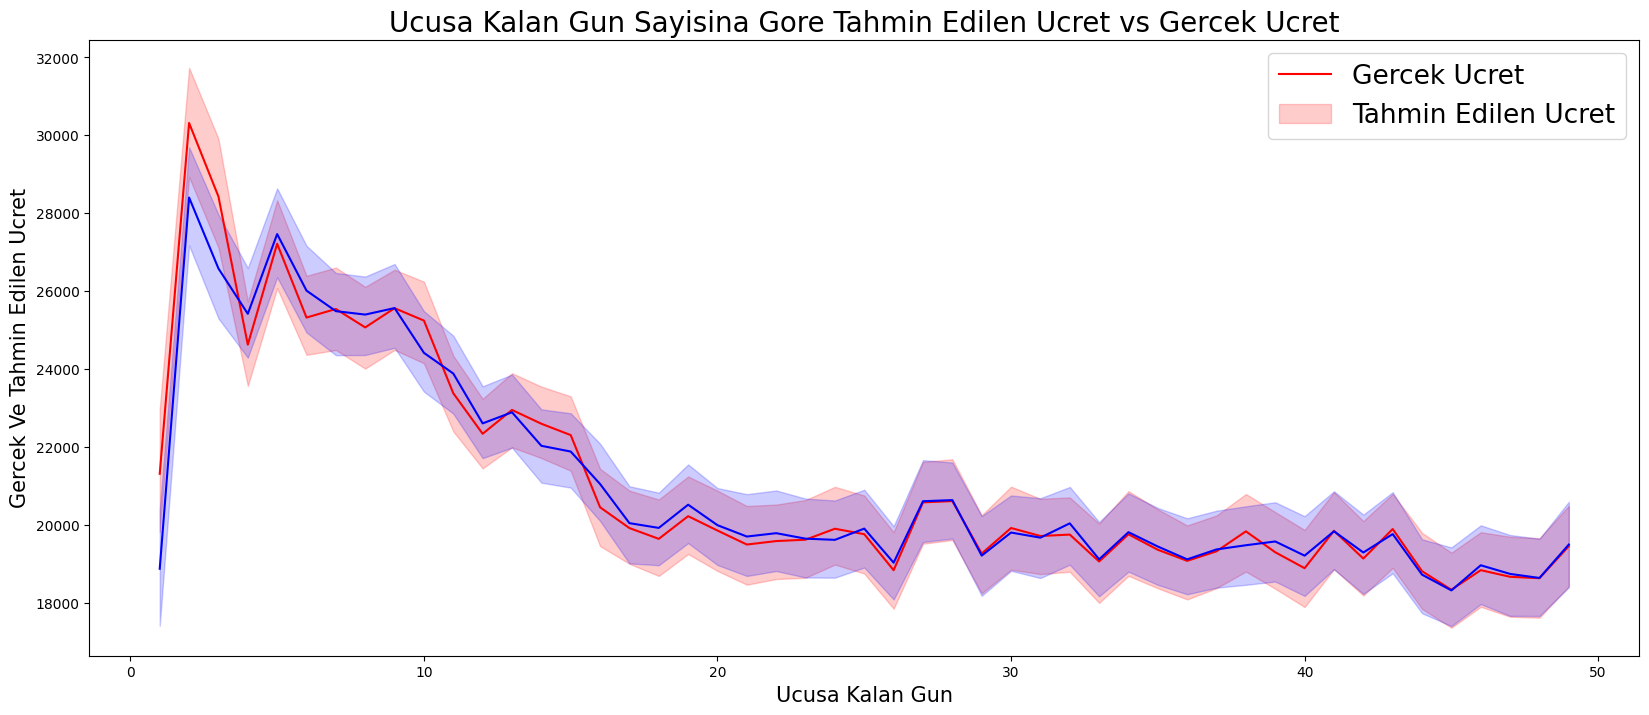

In [26]:
plt.figure(figsize=(20,8))
sns.lineplot(data=sonuc3,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=sonuc3,x='days_left',y='Price_pred',color='blue')
plt.title('Ucusa Kalan Gun Sayisina Gore Tahmin Edilen Ucret vs Gercek Ucret',fontsize=20)
plt.legend(labels=['Gercek Ucret','Tahmin Edilen Ucret'],fontsize=19)
plt.xlabel('Ucusa Kalan Gun',fontsize=15)
plt.ylabel('Gercek Ve Tahmin Edilen Ucret',fontsize=15)
plt.show()

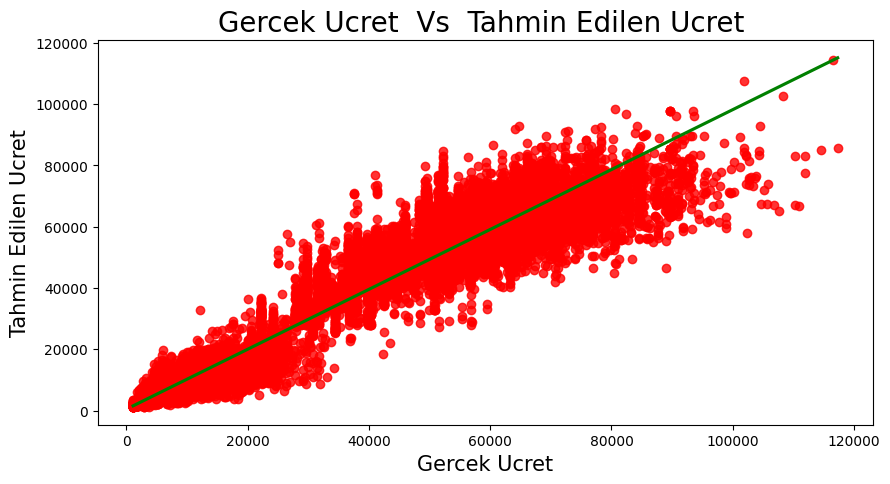

In [27]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=sonuc3,scatter_kws={"color": "red"}, line_kws={"color": "green"})
plt.title('Gercek Ucret  Vs  Tahmin Edilen Ucret ',fontsize=20)
plt.xlabel('Gercek Ucret',fontsize=15)
plt.ylabel('Tahmin Edilen Ucret',fontsize=15)
plt.show()

Linear Regression ile modelin eğitilmesi  

In [28]:
modelmlg.fit(x_train, y_train)

# test verisi ile modelin tahmin edilmesi
y_pred = modelmlg.predict(x_test)

In [29]:
cikti4 = pd.DataFrame({'Price_actual' : y_test, 'Price_pred' : y_pred})
sonuc4 = df_bk.merge(cikti4, left_index = True, right_index = True)

# 10 adet örnek gösterimi
sonuc.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
149845,Vistara,UK-772,Kolkata,Morning,one,Morning,Chennai,Economy,22.42,21,7021,7021,7192.985
16008,Air_India,AI-560,Delhi,Morning,one,Afternoon,Bangalore,Economy,6.17,31,3610,3610,3637.150
262992,Air_India,AI-424,Kolkata,Afternoon,one,Morning,Delhi,Business,19.92,32,43305,43305,43192.570
46862,Air_India,AI-657,Mumbai,Early_Morning,one,Evening,Delhi,Economy,11.58,21,7551,7551,7424.885
32270,Vistara,UK-995,Delhi,Morning,one,Early_Morning,Hyderabad,Economy,21.50,28,5772,5772,5772.000
240327,Vistara,UK-958,Mumbai,Afternoon,one,Evening,Hyderabad,Business,7.50,34,45805,45805,45805.000
139805,Air_India,AI-763,Kolkata,Early_Morning,one,Evening,Bangalore,Economy,9.25,31,7999,7999,7514.260
264286,Air_India,AI-402,Kolkata,Morning,one,Night,Mumbai,Business,11.75,7,50271,50271,50271.000
58344,Air_India,AI-687,Mumbai,Afternoon,one,Morning,Bangalore,Economy,16.92,32,6082,6082,6080.045
26887,Vistara,UK-963,Delhi,Morning,one,Evening,Kolkata,Economy,8.00,39,6578,6578,6684.120


Tahmin ve Gercek Veri Graiği

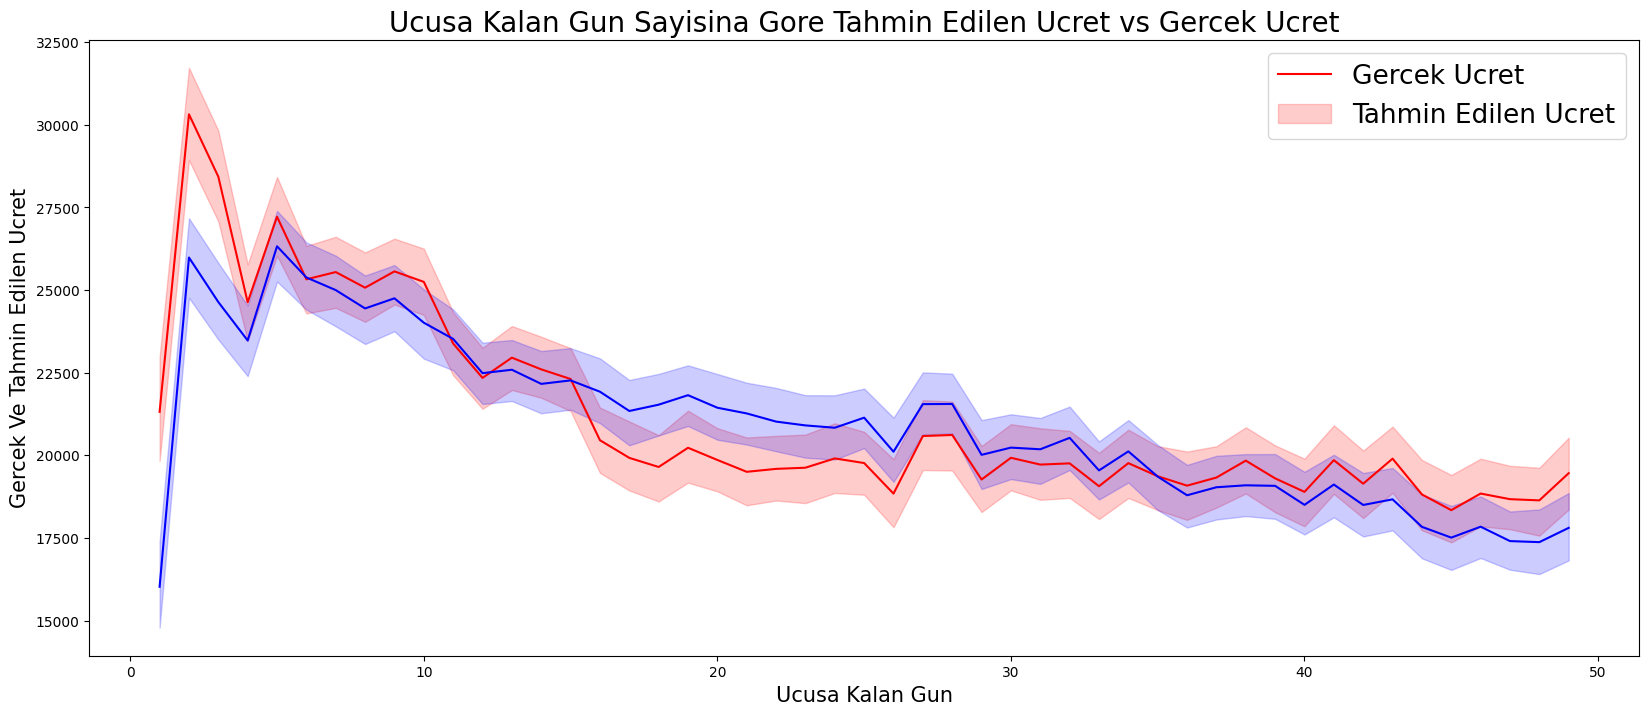

In [30]:
plt.figure(figsize=(20,8))
sns.lineplot(data=sonuc4,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=sonuc4,x='days_left',y='Price_pred',color='blue')
plt.title('Ucusa Kalan Gun Sayisina Gore Tahmin Edilen Ucret vs Gercek Ucret',fontsize=20)
plt.legend(labels=['Gercek Ucret','Tahmin Edilen Ucret'],fontsize=19)
plt.xlabel('Ucusa Kalan Gun',fontsize=15)
plt.ylabel('Gercek Ve Tahmin Edilen Ucret',fontsize=15)
plt.show()

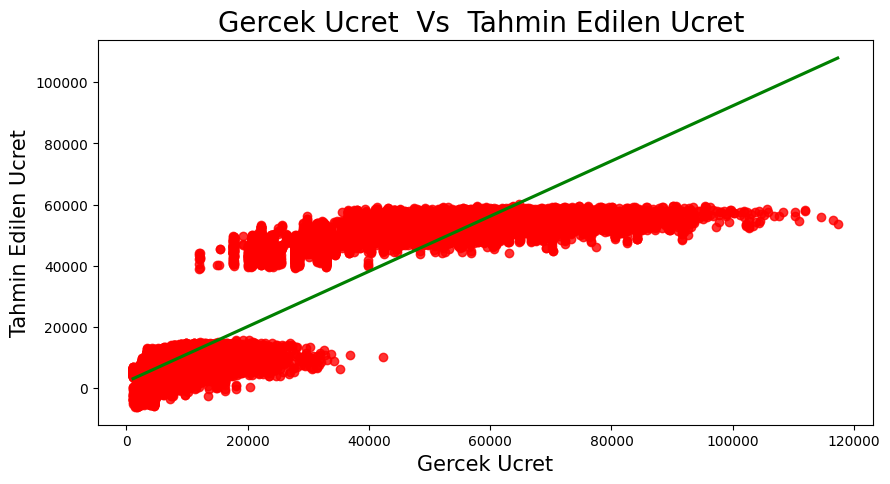

In [31]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=sonuc4,scatter_kws={"color": "red"}, line_kws={"color": "green"})
plt.title('Gercek Ucret  Vs  Tahmin Edilen Ucret ',fontsize=20)
plt.xlabel('Gercek Ucret',fontsize=15)
plt.ylabel('Tahmin Edilen Ucret',fontsize=15)
plt.show()